# La libreta científica de Leyre

Seguro que después de pasar una noche con Daniel, Alba y Quim, ya eres un experto en esto de analizar datos y de programar con python. Y seguramente mucho de lo que hay en mi libreta ya lo sabes hacer sin ayuda. ¡Pero espero poder enseñarte aún alguna cosa nueva!

---------

Para empezar, veamos si hay rayos gamma en los datos que tomamos. La gente de VERITAS estaba muy emocionada. Pero no sería la primera vez que la emoción se transforma en decepción.

El ** Thetaplot ** ya lo tienes controlado, ¿no?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

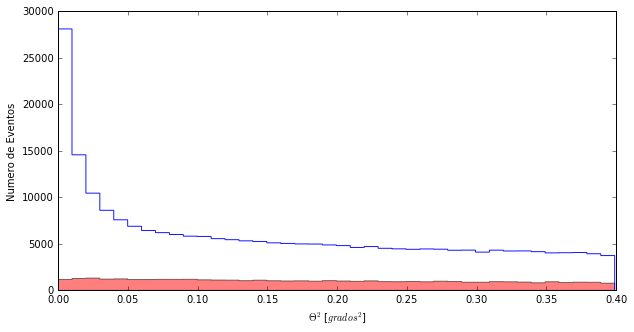

In [2]:
# Leemos los ficheros y les damos un nombre
mrk421_ON= pd.read_csv('data/EvtList_ON_Mrk421.txt', sep=' ')
mrk421_OFF= pd.read_csv('data/EvtList_OFF.txt', sep=' ')

# Definimos la variables de corte had_cut y theta_cut
had_cut = 0.20
theta2_cut = 0.40

# Seleccionamos los datos:
mrk421_ON_cut = mrk421_ON[(mrk421_ON['had'] < had_cut) & (mrk421_ON['theta2'] < theta2_cut)]
mrk421_OFF_cut = mrk421_OFF[(mrk421_OFF['had'] < had_cut) & (mrk421_OFF['theta2'] < theta2_cut)]


pl.figure(1, figsize=(10, 5), facecolor='w', edgecolor='k')
Noff, ThetasOff, _ = pl.hist(mrk421_OFF_cut.theta2, bins=40, histtype='stepfilled', color='red', alpha=0.5, normed=False)
Non, ThetasOn, _ = pl.hist(mrk421_ON_cut.theta2, bins=40, histtype='step', color = 'blue',alpha=0.9, normed=False)
pl.xlabel('$\Theta^2$ [$grados^2$]')
pl.ylabel('Numero de Eventos')
pl.show()

¡¡¡Cierto!!! Como Mrk 421 estava en flare no perdimos el tiempo tomando OFF data, tomamos tanto ON como pudimos. Nunca se sabe cuanto va a durar un flare. Así que estuvimos básicamente 3 horas seguidas tomando datos ON de Mrk 421. Y claro, ahora los eventos ** ON ** y ** OFF ** no me coinciden.

Bueno, esto tiene una solución fácil. Lo que realmente me interesa es saber cuál es el ** OFF ** en la zona donde hay señal: valores de ** Theta Cuadrado ** pequeños. Así que puedo buscar por qué factor tengo que multiplicar el ** OFF ** para que me coincida con el ** ON ** a valores de ** Theta Cuadrado ** grandes (entre 0.25 y 0.35, por ejemplo). Este factor lo uso para escalara todo el ** OFF ** y ya tengo una buena estimación de cuantos eventos de ** ON ** no son rayos gamma que vengan de Mrk 421. 


In [3]:
eventos_off =  sum(Noff[26:35])
eventos_on = sum(Non[26:35])
factor = eventos_on / eventos_off
print ("Necesitamos escalar el OFF por un factor: ", factor)

('Necesitamos escalar el OFF por un factor: ', 4.7118271695349687)


Ya tengo el factor de escala, ¿entiendes cómo lo he hecho? Ahora veamos como lo aplico a todos los eventos de las observaciones ** OFF **.

La forma más fácil de hacerlo es con pesos ... 'weights' en inglés, que es el idioma básico que usa Python.

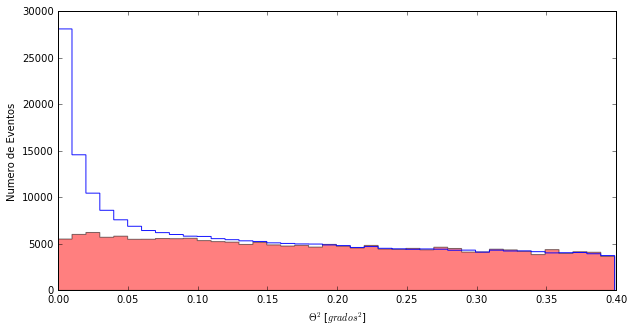

In [4]:
pl.figure(2, figsize=(10, 5), facecolor='w', edgecolor='k')
# Creamos una variable 'weights'. Y la llenamos de unos (ones_like) multiplicado por
# el factor que acabamos de encontrar
weights = np.ones_like(mrk421_OFF_cut.theta2)*factor
# Y ahora solo hace falta añadir a la función que ya conocemos: pl.hist, un parámetro:
# weights=weights
Noff, ThetasOff, _ = pl.hist(mrk421_OFF_cut.theta2, bins=40, histtype='stepfilled', color='red', alpha=0.5, normed=False, weights=weights)
Non, ThetasOn, _ = pl.hist(mrk421_ON_cut.theta2, bins=40, histtype='step', color = 'blue',alpha=0.9, normed=False)
pl.xlabel('$\Theta^2$ [$grados^2$]')
pl.ylabel('Numero de Eventos')
pl.show()

¡¡¡Wow!!! Pues si, estaba en flare. Tengo más rayos gammas en 3 horas (concretamente 10000 segundos) de los que nunca tendrán Daniel, Alba y Quim.

--------

Y de hecho, con tantos  rayos gamma podemos mirar si el número que nos llegan cambia con el tiempo. Porque, de hecho, en esto consisten los flares: el número de rayos gamma que nos llegan de un sitio aumenta por un cierto tiempo.

Para eso, lo primero que necesito es leer el tiempo de llegada de cada evento ** ON **. Usaré siempre el mismo ** OFF **, que no cambia con el tiempo.

Nuestros datos incorporan una columna nueva llamada **Tiempo** que nos indica el momento en que el telescopio detecta los rayos gamma. 

In [5]:
mrk421_ON_cut.head()

,Energia,had,theta2,Tiempo
24,90.0,0.130,0.333,8346.26
31,172.0,0.006,0.003,9033.70
32,85.0,0.062,0.239,1300.29
34,61.0,0.159,0.268,2116.28
54,3081.0,0.196,0.204,7509.42


Y para usar la columna **Tiempo**, tanto en el ON como en el OFF sabes que solo hay que hacer:
> mrk421_ON_cut.Tiempo

----------
Ahora quiero ver cómo los rayos gamma nos llegan a medida que pasan los segundos. Recordad que esto es un flare, una explosión, así que esperamos que el número de Gammas cambie con el tiempo rápidamente. Pero lo mejor es verlo con nuestros ojos.

Esta gráfica que buscamos se llama **Lightcurve**(curva de luz) y nos muestra el número de excesos (** ON - OFF **) que tengo en cada intervalo de tiempo.

Así es como se pueden hacer los cálculos y la gráfica.

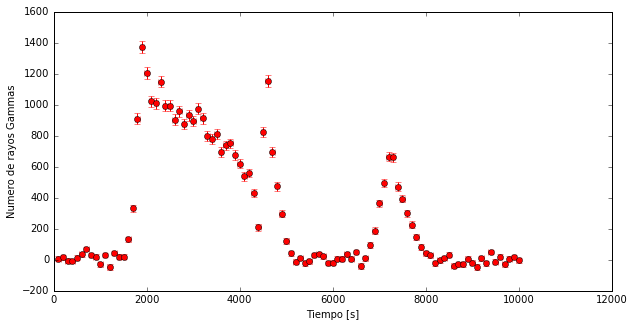

In [5]:
#Cómo calcular un Lightcurve

# 1 Preparamos los datos teniendo en cuenta que los excesos los calculamos con:
#    a/ Después del corte en hadronness
#    b/ Usando los eventos en los dos primeros bin del Theta Plot, 
#       es decir Theta Cuadrado < 0.02
#    c/ Con el OFF y el ON normalizados
had_cut = 0.20
theta2_cut = 0.02
mrk421_ON_cut_LightCurve = mrk421_ON[(mrk421_ON['had'] < had_cut) & (mrk421_ON['theta2'] < theta2_cut)]
mrk421_OFF_cut_LightCurve = mrk421_OFF[(mrk421_OFF['had'] < had_cut) & (mrk421_OFF['theta2'] < theta2_cut)]
weights = np.ones_like(mrk421_OFF_cut_LightCurve.theta2)*factor

# 2 Calcular Non y Noff para cada intervalo de tiempo. 
# Vamos a definir 100 intervalos (bins) en los 10000 segundos de nuestros datos
bins =100
Non, tiempos= np.histogram(mrk421_ON_cut_LightCurve.Tiempo, bins=bins)
Noff, bins_off= np.histogram(mrk421_OFF_cut_LightCurve.Tiempo, bins=tiempos, weights=weights)

# 3 Calcular el Exceso y su Error para cada intervalo de tiempo.
Exceso= Non - Noff
Error= (Non + Noff)**0.5

# 4 Representar el lightcurve: los excesos con sus errores a lo largo del tiempo
pl.figure(1, figsize=(10, 5), facecolor='w', edgecolor='k')
pl.errorbar(tiempos[1:], Exceso, xerr=10000.0/(2.0*bins), yerr= Error, fmt='or', ecolor='red')
pl.xlabel('Tiempo [s]')
pl.ylabel('Numero de rayos Gammas')
pl.show()

¡Genial! La cantidad de rayos gamma cambia y lo hace muy rápido. Cuando tenemos la suerte de observar un flare así, podemos sacar mucha información. Tanto de la fuente en si y de los procesos que ocurren en ella, como de qué les pasa a los rayos gamma mientras viajan desde la fuente hasta la tierra. ¡A mi lo que más me interesa es esta segunda parte!

-------
Nota:  
A diferencia del ** Thetaplot ** , en el paso 4 no quiero representar cuantas veces sucede algo en mis datos. Quiero mostrar una variable (Número de Excesos) en función de otra (Tiempo), con sus errores. Para eso no puedo usar "pl.hist". Por eso uso otra función que hace exactamente lo que necesito:

> pl.errorbar(VariableEjeX, VariableEjeY)

Además se le pueden dar parámetros adicionales para definir:

> Error en el Eje X: xerr = ???
> Error en el Eje Y: yerr = ???
> Formato de los puntos: fmt ='or', o para tener un círculo en cada punto y r para que sea rojo
> Color para representar los errores: ecolor = 'red'

Así representamos el número de excesos en función del tiempo, esto es lo que llamamos ** Light Curve ** (curva de luz).

--------

Ahora vamos a representar los datos de una forma distinta:

Vemos cómo cambian con el tiempo los rayos Gamma que detecta la cámara del telescopio en los 10000 segundos que dura el flare. Si te fijas puedes ver claramente cuándo se produce el flare en el ON, mientras en el OFF todo sigue igual. Y, claro, coincide con los picos del lightcurve. Los eventos se concentran en el centro de la cámara porque estamos apuntando a Mrk421.

Por qué hay detecciones que son circunferencias? El tamaño de los eventos representa su energía.

In [1]:
from IPython.display import HTML
HTML("""
<video width="600" height="600" controls="" autoplay="" loop="">
  <source src="data/animation_ONOFF.mp4" type="video/mp4">
</video>
""")